In [43]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm, linear_model, metrics
import numpy as np
import string
import random
import string
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from nltk.corpus import stopwords
from nltk.stem.porter import *
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler


In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        try:
            yield eval(l)
        except:
            continue

In [18]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [19]:
dataset = []
for d in readGz("renttherunway_final_data.json.gz"):
    dataset.append(d)


In [20]:
len(dataset)

192462

In [21]:
def heightConversion(h):
    ft, inch = h.split('\' ')
    ft = int(ft)
    inch = int(inch.replace('\"', ''))
    return ft * 12 + inch

In [22]:
new_dataset = []
punctuation = set(string.punctuation)

for d in dataset:
    feature_needed = ['weight', 'height', 'fit', 'size', 'body type', 'review_text', 'review_summary', 'rating']
    keys = list(d.keys())
    if all([i in keys for i in feature_needed]):
        d['weight'] = int(d['weight'].replace("lbs", ""))
        d['height'] = heightConversion(d['height'])
        new_dataset.append(d)

In [23]:
len(new_dataset)

153441

In [24]:
y1 = [d['fit'] for d in new_dataset]

In [25]:
y1 = [d['fit'] for d in new_dataset]
pd.Series(y1).value_counts(normalize=True)

fit      0.736035
small    0.134019
large    0.129946
dtype: float64

In [26]:
dataTrain1, data_vt1, ytrain1, y_vt1 = train_test_split(new_dataset, y1, test_size=0.3, random_state=42)
dataValid1, dataTest1, yvalid1, ytest1 = train_test_split(data_vt1, y_vt1, test_size=0.5, random_state=42)
len(dataTrain1), len(dataValid1), len(dataTest1)

(107408, 23016, 23017)

In [27]:
Xtrain1 = [[1, d['weight'], d['height'], d['size']] for d in dataTrain1]
Xvalid1 = [[1, d['weight'], d['height'], d['size']] for d in dataValid1]
Xtest1 = [[1, d['weight'], d['height'], d['size']] for d in dataTest1]

In [28]:
m = DecisionTreeClassifier()
m.fit(Xtrain1,ytrain1)
v1 = metrics.f1_score(yvalid1, m.predict(Xvalid1), average='weighted',zero_division=0)
t1 = metrics.f1_score(ytest1, m.predict(Xtest1), average='weighted',zero_division=0)
v1, t1

(0.6276544810790455, 0.6376694861117402)

In [29]:
m4 = linear_model.LogisticRegression()
m4.fit(Xtrain1,ytrain1)
v4 = metrics.f1_score(yvalid1, m4.predict(Xvalid1), average='weighted',zero_division=0)
t4 = metrics.f1_score(ytest1, m4.predict(Xtest1), average='weighted',zero_division=0)
v4, t4

(0.6217622231791451, 0.6296347930272238)

In [30]:
m5 = linear_model.SGDClassifier()
m5.fit(Xtrain1,ytrain1)
v5 = metrics.f1_score(yvalid1, m5.predict(Xvalid1), average='weighted',zero_division=0)
t5 = metrics.f1_score(ytest1, m5.predict(Xtest1), average='weighted',zero_division=0)
v5, t5

(0.6211585514058244, 0.628687804935247)

In [31]:
m6 = svm.LinearSVC()
m6.fit(Xtrain1,ytrain1)
v6 = metrics.f1_score(yvalid1, m6.predict(Xvalid1), average='weighted',zero_division=0)
t6 = metrics.f1_score(ytest1, m6.predict(Xtest1), average='weighted',zero_division=0)
v6, t6

(0.5766491081557076, 0.5837427186425724)

In [32]:
# Baseline Model - using only weight, height and size
mods = {}
F1Valid = {}
F1Train = {}
F1scores = []
bestMod = None
bestVal = None
bestI = None
for i in range(2,25):
    baselineMod = DecisionTreeClassifier(max_depth=i)
    baselineMod.fit(Xtrain1,ytrain1)
    mods[i] = baselineMod
    blPred = baselineMod.predict(Xvalid1)
    blF1 = metrics.f1_score(yvalid1, blPred, average='weighted',zero_division=0)
    F1Valid[i] = blF1
    blPredTr = baselineMod.predict(Xtrain1)
    blF1Tr = metrics.f1_score(ytrain1, blPredTr, average='weighted',zero_division=0)
    F1Train[i] = blF1Tr
    F1scores.append(blF1)
    print("Max_depth = {}, F_1 score is {}.".format(str(i), str(blF1)))
    if bestVal == None or blF1 > bestVal:
        bestVal = blF1
        bestMod = baselineMod
        bestI = i

Max_depth = 2, F_1 score is 0.6211854113684363.
Max_depth = 3, F_1 score is 0.6211854113684363.
Max_depth = 4, F_1 score is 0.6211854113684363.
Max_depth = 5, F_1 score is 0.6211854113684363.
Max_depth = 6, F_1 score is 0.6211797652217251.
Max_depth = 7, F_1 score is 0.6212300680822704.
Max_depth = 8, F_1 score is 0.6235943992050079.
Max_depth = 9, F_1 score is 0.6225766046133574.
Max_depth = 10, F_1 score is 0.6236863565220943.
Max_depth = 11, F_1 score is 0.6244503778630027.
Max_depth = 12, F_1 score is 0.6248224349560061.
Max_depth = 13, F_1 score is 0.6252816084849351.
Max_depth = 14, F_1 score is 0.625463102322912.
Max_depth = 15, F_1 score is 0.6260997785086501.
Max_depth = 16, F_1 score is 0.6272630485601155.
Max_depth = 17, F_1 score is 0.6275749414170815.
Max_depth = 18, F_1 score is 0.6282678558857953.
Max_depth = 19, F_1 score is 0.6278101531842865.
Max_depth = 20, F_1 score is 0.6278560247691524.
Max_depth = 21, F_1 score is 0.6279177334232454.
Max_depth = 22, F_1 score is 

In [33]:
bestI, bestVal

(18, 0.6282678558857953)

In [34]:
predTest = bestMod.predict(Xtest1)
f1Test1 = metrics.f1_score(ytest1, predTest, average='weighted',zero_division=0)
f1Test1

0.6371195078939729

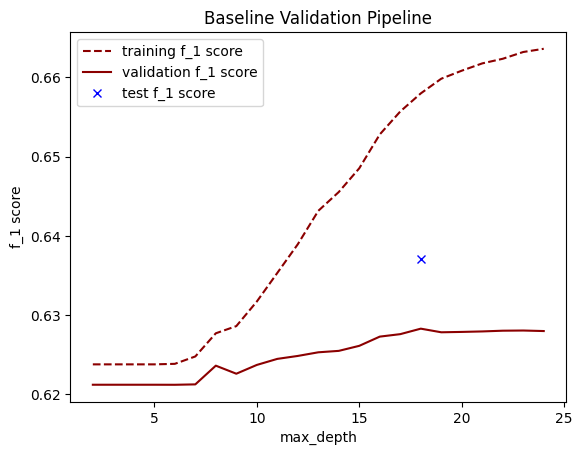

In [35]:
plt.xticks([])
plt.xlabel(r"max_depth")
plt.ylabel(r"f_1 score")
plt.title(r"Baseline Validation Pipeline")
plt.xscale('linear')
plt.plot(range(2,25), list(F1Train.values()), color='darkred', linestyle='--', label='training f_1 score')
plt.plot(range(2,25), list(F1Valid.values()), color='darkred',zorder=4,label="validation f_1 score")
plt.plot([bestI], [f1Test1], linestyle='', marker='x', color='blue', label="test f_1 score")
plt.legend(loc='best')
plt.show()

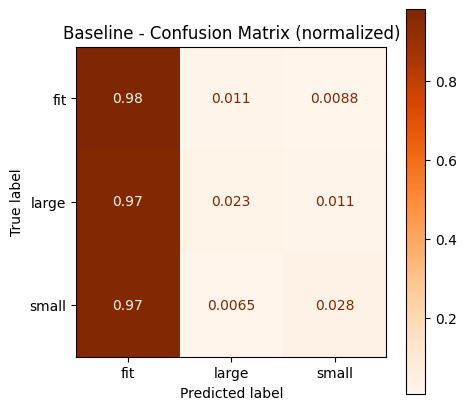

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
metrics.plot_confusion_matrix(bestMod, Xtest1, ytest1, ax=ax, normalize='true',cmap='Oranges')
plt.title('Baseline - Confusion Matrix (normalized)')
plt.show()

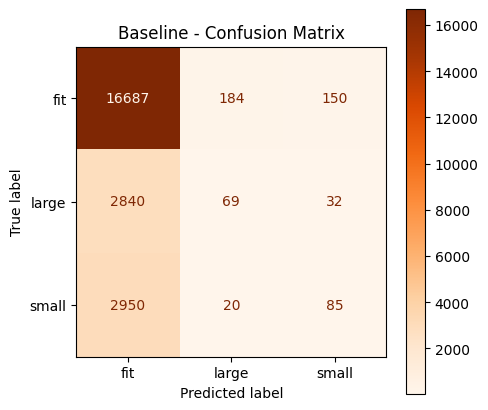

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
metrics.plot_confusion_matrix(bestMod, Xtest1, ytest1, ax=ax,cmap='Oranges')
plt.title('Baseline - Confusion Matrix')
plt.show()

In [194]:
wordCount2 = defaultdict(int)
punctuation2 = set(string.punctuation)
stemmer2 = PorterStemmer()
sw2 = stopwords.words("English")
for d in dataTrain1:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation2])
    s = ''.join([c for c in d['review_summary'].lower() if not c in punctuation2])
    for w in r.split() + s.split():
        w = stemmer2.stem(w)
        wordCount2[w] += 1

len(wordCount2)

31232

In [195]:
counts2 = [(wordCount2[w],w) for w in wordCount2 if w not in sw2]
counts2.sort()
counts2.reverse()
len(counts2)

31117

In [196]:
words2 = [x[1] for x in counts2[:4000]]

In [197]:
wordId2 = dict(zip(words2, range(len(words2))))
wordSet2 = set(words2)

In [198]:
def feature3(d): 
    feat = [0]*len(words2)
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation2])
    s = ''.join([c for c in d['review_summary'].lower() if not c in punctuation2])
    for w in r.split() + s.split():
        w = stemmer2.stem(w)
        if w in words2:
            feat[wordId2[w]] += 1
    return [1] + [d['weight'], d['height'], d['size']] + feat

In [201]:
Xtrain3 = [feature3(d) for d in dataTrain1]

In [199]:
Xvalid3 = [feature3(d) for d in dataValid1]

In [200]:
Xtest3 = [feature3(d) for d in dataTest1]

In [ ]:
# p = Pipeline([
#     ('under', RandomUnderSampler(sampling_strategy='majority')), 
#     ('model', DecisionTreeClassifier())
#     ])
# # evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(p, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
# score = mean(scores)
# print('F1 Score: %.3f' % score)

In [60]:
# rs = RandomUnderSampler(sampling_strategy='majority')
# data_clean, y_clean = rs.fit_resample(pd.DataFrame(new_dataset), y1)

In [110]:
pd.Series(y1).value_counts()

fit      112938
small     20564
large     19939
dtype: int64

In [95]:
fitting = pd.Series(y1).value_counts()
sample_size = (fitting['small'] + fitting['large'])//2

df_new = pd.DataFrame(new_dataset)
fit_only = df_new[df_new['fit'] == 'fit']
undersample = fit_only.sample(n=sample_size).reset_index(drop=True) # undersampling
df_resample = undersample.append(df_new[df_new['fit'] == 'small']).append(df_new[df_new['fit'] == 'large']).reset_index(drop=True)
y_resample = df_resample['fit']

(42527, 9113, 9114)

In [228]:
df_resample.shape

(60754, 15)

In [111]:
pd.Series(y_resample).value_counts()

small    20564
fit      20251
large    19939
Name: fit, dtype: int64

In [108]:
sw2 = stopwords.words("English")
stemmer2 = PorterStemmer()
df_resample['review_text'] = df_resample['review_text'].str.lower().str.replace('[^\w\s]','').apply(lambda i: ' '.join(['' if stemmer2.stem(j) in sw2 else stemmer2.stem(j) for j in i.split()]))
df_resample['review_summary'] = df_resample['review_summary'].str.lower().str.replace('[^\w\s]','').apply(lambda i: ' '.join(['' if stemmer2.stem(j) in sw2 else stemmer2.stem(j) for j in i.split()]))

In [122]:
d_tr, d_vt, y_tr, y_vt = train_test_split(df_resample, y_resample, test_size=0.3, random_state=42)
d_va, d_te, y_va, y_te = train_test_split(d_vt, y_vt, test_size=0.5, random_state=42)
len(d_tr), len(d_va), len(d_te)

(42527, 9113, 9114)

In [128]:
d_tr['fit'].value_counts(), d_va['fit'].value_counts(), d_te['fit'].value_counts()

(small    14409
 fit      14188
 large    13930
 Name: fit, dtype: int64,
 small    3105
 large    3035
 fit      2973
 Name: fit, dtype: int64,
 fit      3090
 small    3050
 large    2974
 Name: fit, dtype: int64)

In [113]:
words_only = (df_resample['review_text'] + df_resample['review_summary']).str.split()

In [116]:
wordcount = defaultdict(int)
h = [pd.Series(words_only.iloc[i]).value_counts().to_dict() for i in range(len(words_only))]
for d in h:
    for key, value in d.items():
        wordcount[key] += value

In [118]:
len(wordcount)

43597

In [117]:
counts = [(wordcount[w],w) for w in wordcount]
counts.sort()
counts.reverse()
counts[:10]

[(109001, 'dress'),
 (37106, 'fit'),
 (36085, 'size'),
 (32758, 'wear'),
 (23988, 'would'),
 (21717, 'love'),
 (20150, 'wore'),
 (19683, 'littl'),
 (18865, 'great'),
 (17970, 'compliment')]

In [119]:
words = [x[1] for x in counts[:10000]]

In [138]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [162]:
def feature4(df): 
    feat1 = []
    v = df['review_text'].str.lower().str.replace('[^\w\s]','').apply(lambda i: ' '.join(['' if j in sw2 else j for j in i.split()]))
    v2 = df['review_summary'].str.lower().str.replace('[^\w\s]','').apply(lambda i: ' '+' '.join(['' if j in sw2 else j for j in i.split()]))
    for l in v+v2:
        feat = [0]*len(words)
        for w in l.split():
            if w in words:
                feat[wordId[w]] += 1
        feat1.append(feat)
    return feat1

In [163]:
X_tr = feature4(d_tr)

In [164]:
X_va = feature4(d_va)

In [165]:
X_te = feature4(d_te)

In [167]:
Xtrain_new = pd.Series([[1] + d_tr[['weight', 'height','size']].iloc[i].to_list() for i in range(len(d_tr))]) + pd.Series(X_tr)

In [168]:
Xtrain_new

0        [1, 150, 67, 16, 4, 1, 1, 2, 1, 1, 0, 0, 1, 0,...
1        [1, 105, 66, 8, 2, 0, 2, 0, 1, 0, 0, 0, 3, 0, ...
2        [1, 115, 62, 8, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...
3        [1, 135, 64, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4        [1, 175, 64, 20, 2, 0, 0, 1, 1, 4, 1, 0, 0, 0,...
                               ...                        
42522    [1, 110, 64, 1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...
42523    [1, 142, 67, 17, 3, 2, 0, 1, 0, 0, 1, 2, 1, 1,...
42524    [1, 120, 64, 8, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, ...
42525    [1, 125, 67, 12, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0,...
42526    [1, 150, 71, 12, 2, 0, 3, 0, 2, 2, 2, 0, 0, 0,...
Length: 42527, dtype: object

In [169]:
Xvalid_new = pd.Series([[1] + d_va[['weight', 'height','size']].iloc[i].to_list() for i in range(len(d_va))]) + pd.Series(X_va)

In [170]:
Xtest_new = pd.Series([[1] + d_te[['weight', 'height','size']].iloc[i].to_list() for i in range(len(d_te))]) + pd.Series(X_te)

In [184]:
# Track the model which works best on the validation set
bestModel = None
bestValue = None
bestC = None
models = dict()
accValid = dict()
accTrain = dict()

for c in range(2,25):
    model = DecisionTreeClassifier(max_depth=c, criterion='entropy')
    model.fit(list(Xtrain_new), y_tr)
    models[c] = model
    predictValid = model.predict(list(Xvalid_new))
    accV = metrics.accuracy_score(y_va, predictValid)
    accValid[c] = accV
    predictTrain = model.predict(list(Xtrain_new))
    accT = metrics.accuracy_score(y_tr, predictTrain)
    accTrain[c] = accT
    print("Max_depth = {}, validation accuracy = {}.".format(c, accV))
    if bestValue == None or accV > bestValue:
        bestValue = accV
        bestModel = model
        bestC = c

Max_depth = 2, validation accuracy = 0.5080654010753868.
Max_depth = 3, validation accuracy = 0.5505322067376276.
Max_depth = 4, validation accuracy = 0.5947547459672995.
Max_depth = 5, validation accuracy = 0.5977175463623395.
Max_depth = 6, validation accuracy = 0.6277844837045978.
Max_depth = 7, validation accuracy = 0.638648085153078.
Max_depth = 8, validation accuracy = 0.6525842203445628.
Max_depth = 9, validation accuracy = 0.6504992867332382.
Max_depth = 10, validation accuracy = 0.6542302205640295.
Max_depth = 11, validation accuracy = 0.6517063535608472.
Max_depth = 12, validation accuracy = 0.6501700866893448.
Max_depth = 13, validation accuracy = 0.6530231537364205.
Max_depth = 14, validation accuracy = 0.6512674201689893.
Max_depth = 15, validation accuracy = 0.644793152639087.
Max_depth = 16, validation accuracy = 0.6431471524196203.
Max_depth = 17, validation accuracy = 0.6383188851091847.
Max_depth = 18, validation accuracy = 0.6400746186766159.
Max_depth = 19, validati

In [192]:
bestC, bestValue

(10, 0.6542302205640295)

In [188]:
te_pred = bestModel.predict(list(Xtest_new))
accTest = metrics.accuracy_score(y_te, te_pred)
accTest

0.6511959622558701

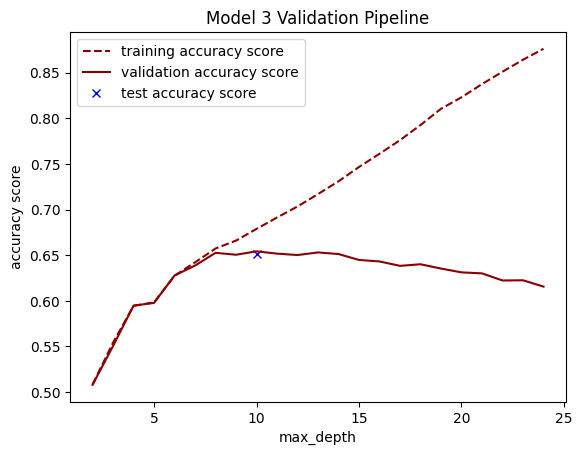

In [221]:
plt.xticks([])
plt.xlabel(r"max_depth")
plt.ylabel(r"accuracy score")
plt.title(r"Model 3 Validation Pipeline")
plt.xscale('linear')
plt.plot(range(2,25), list(accTrain.values()), color='darkred', linestyle='--', label='training accuracy score')
plt.plot(range(2,25), list(accValid.values()), color='darkred',zorder=4,label="validation accuracy score")
plt.plot([bestC], [accTest], linestyle='', marker='x', color='blue', label="test accuracy score")
plt.legend(loc='best')
plt.show()

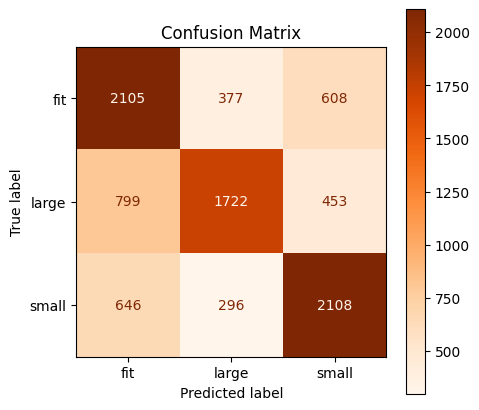

In [190]:
fig, ax = plt.subplots(figsize=(5, 5))
metrics.plot_confusion_matrix(bestModel, list(Xtest_new), y_te, ax=ax,cmap='Oranges')
plt.title('Confusion Matrix')
plt.show()

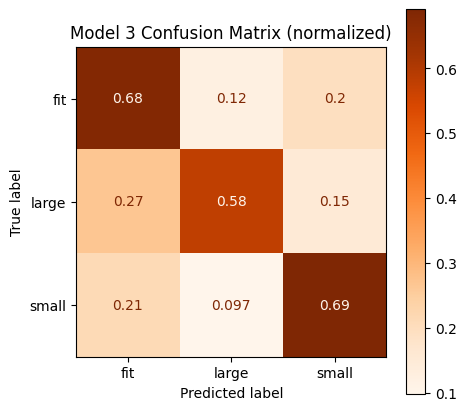

In [222]:
fig, ax = plt.subplots(figsize=(5, 5))
metrics.plot_confusion_matrix(bestModel, list(Xtest_new), y_te, ax=ax,normalize='true',cmap='Oranges')
plt.title('Model 3 Confusion Matrix (normalized)')
plt.show()

In [202]:
# Track the model which works best on the validation set
bestModel2 = None
bestValue2 = None
bestC2 = None
models2 = dict()
f1Valid2 = dict()
f1Train2 = dict()

for c in range(2,25):
    model2 = DecisionTreeClassifier(max_depth=c, criterion='entropy')
    model2.fit(Xtrain3, ytrain1)
    models[c] = model2
    predictValid2 = model2.predict(Xvalid3)
    f1V2 = metrics.f1_score(yvalid1, predictValid2, average='weighted', zero_division=0)
    f1Valid2[c] = f1V2
    predictTrain2 = model2.predict(Xtrain3)
    f1T2 = metrics.f1_score(ytrain1, predictTrain2, average='weighted', zero_division=0)
    f1Train2[c] = f1T2
    print("Max_depth = " + str(c) + ", validation F_1 score = " + str(f1V2))
    if bestValue2 == None or f1V2 > bestValue:
        bestValu2 = f1V2
        bestModel2 = model2
        bestC2 = c

Max_depth = 2, validation F_1 score = 0.711063843720865
Max_depth = 3, validation F_1 score = 0.7227264169845059
Max_depth = 4, validation F_1 score = 0.7165984149428051
Max_depth = 5, validation F_1 score = 0.7515828225868005
Max_depth = 6, validation F_1 score = 0.7535102396082333
Max_depth = 7, validation F_1 score = 0.7588805568032273
Max_depth = 8, validation F_1 score = 0.7633089549334894
Max_depth = 9, validation F_1 score = 0.7658793698194163
Max_depth = 10, validation F_1 score = 0.7683208149311683
Max_depth = 11, validation F_1 score = 0.765465747381606
Max_depth = 12, validation F_1 score = 0.7632879774698966
Max_depth = 13, validation F_1 score = 0.7621022890426358
Max_depth = 14, validation F_1 score = 0.7643331508740109
Max_depth = 15, validation F_1 score = 0.7610846040331336
Max_depth = 16, validation F_1 score = 0.7610105252218693
Max_depth = 17, validation F_1 score = 0.7588244147605452
Max_depth = 18, validation F_1 score = 0.7554309414830689
Max_depth = 19, validati

In [213]:
bestC2, bestValue2

(10, 0.7683208149311683)

In [217]:
predictTest2 = bestModel2.predict(Xtest3)
f1Test2 = metrics.f1_score(ytest1, predictTest2, average='weighted',zero_division=0)
f1Test2

0.7710398216696802

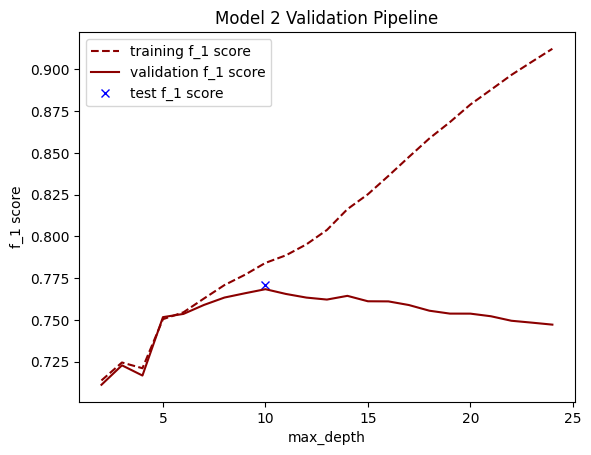

In [224]:
plt.xticks([])
plt.xlabel(r"max_depth")
plt.ylabel(r"f_1 score")
plt.title(r"Model 2 Validation Pipeline")
plt.xscale('linear')
plt.plot(range(2,25), list(f1Train2.values()), color='darkred', linestyle='--', label='training f_1 score')
plt.plot(range(2,25), list(f1Valid2.values()), color='darkred',zorder=4,label="validation f_1 score")
plt.plot([bestC2], [f1Test2], linestyle='', marker='x', color='blue', label="test f_1 score")
plt.legend(loc='best')
plt.show()

In [ ]:
Xtest3

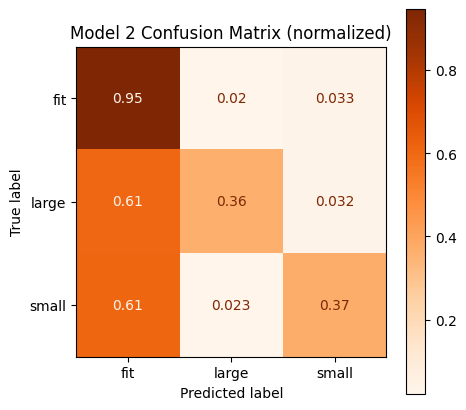

In [226]:
fig, ax = plt.subplots(figsize=(5, 5))
metrics.plot_confusion_matrix(bestModel2, Xtest3, ytest1, ax=ax, normalize='true',cmap='Oranges')
plt.title('Model 2 Confusion Matrix (normalized)')
plt.show()

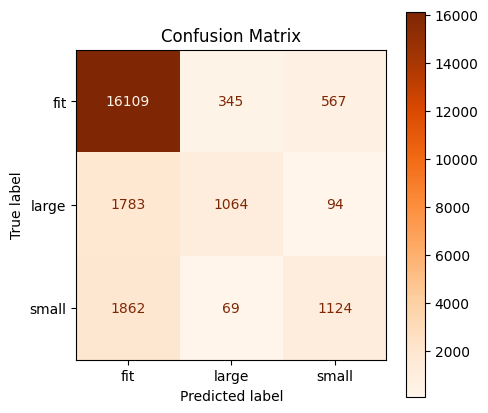

In [227]:
fig, ax = plt.subplots(figsize=(5, 5))
metrics.plot_confusion_matrix(bestModel2, Xtest3, ytest1, ax=ax,cmap='Oranges')
plt.title('Confusion Matrix')
plt.show()